# Week 8: Object Detection

# 预备知识:
- 会使用pytorch搭建简单的cnn
- 熟悉神经网络的训练过程与优化方法
- 结合理论课的内容，了解目标检测的几种经典算法(如Faster RCNN/YOLO/SSD)的内容和原理


# 声明：
- 本次实验课的代码来源于github上的一个开源项目，链接为:[https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection#training](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection)   
- 在该项目的基础上，为了便于同学们更好地去理解代码，我们在此基础上对代码做了略微的修改  
- 由于目标检测任务整个代码逻辑比较复杂，需要理解的细节非常多，因此在本次实验课内容设计过程中我们有幸邀请到了李伟鹏同学，他全程参与了课件的制作过程。

## 网络结构
SSD采用VGG16作为基础模型，然后在VGG16的基础上新增了卷积层来获得更多的特征图以用于检测。SSD的网络结构如图所示。
![network](picture/network.jpg)
采用VGG16做基础模型，分别将VGG16的全连接层fc6和fc7转换成 $3\times3$ 卷积层 conv6和 $1\times1$ 卷积层conv7，同时将池化层pool5由原来的stride=2的 $2\times 2$ 变成stride=1的 $3\times 3$ （猜想是不想reduce特征图大小），为了配合这种变化，采用了一种Atrous Algorithm，其实就是conv6采用扩展卷积或带孔卷积（Dilation Conv），然后移除dropout层和fc8层，并新增一系列卷积层，在检测数据集上做finetuing。  
其中VGG16中的Conv4_3层将作为用于检测的第一个特征图。conv4_3层特征图大小是 $38\times38$ ，但是该层比较靠前，其norm较大，所以在其后面增加了一个L2 Normalization层.

## 先验框
![prior_box](picture/prior_box.jpg)
SSD借鉴了Faster R-CNN中anchor的理念，每个单元设置尺度或者长宽比不同的先验框，预测的边界框（bounding boxes）是以这些先验框为基准的，在一定程度上减少训练难度。一般情况下，每个单元会设置多个先验框，其尺度和长宽比存在差异，如图所示，可以看到每个单元使用了4个不同的先验框，图片中猫和狗分别采用最适合它们形状的先验框来进行训练。

## Dataset
目标检测任务的数据集的构成形式与之前学习的分类任务有很大的区别，传统的分类问题的的dataset里面大致包含  
__\[image,label]__,  
由于目标检测既要做检测框的回归任务又要做检测框内物体的分割任务，因此数据集的构成形式大致如下  
__\[{'boxes':[[ground_truth坐标1],[ground_truth坐标2]，...]},{'labels':[ground_truth标签1，ground_truth标签2，...]}]__  
由于数据集并没有一个规整的格式，处理此类问题我们通常考虑使用Json文件来做存储

首先要将数据集提供的txt文件转换成.json文件，方便后面的重写的dataset函数load数据
create-data_lists()主要的功能就是将图片和它的ground_truth_box以及box对应的标签连接起来存到json文件中。  
__注意：__此函数必须运行一次。

In [1]:
from utils import *
create_data_lists(voc07_path='./data1/VOC2007',output_folder='./json1/')


There are 200 training images containing a total of 600 objects. Files have been saved to /home/jovyan/week8/json1.

There are 200 validation images containing a total of 600 objects. Files have been saved to /home/jovyan/week8/json1.


In [7]:
import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image
from utils import transform


class PascalVOCDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, split, keep_difficult=False):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        :param keep_difficult: keep or discard objects that are considered difficult to detect?
        """
        self.split = split.upper()

        assert self.split in {'TRAIN', 'TEST'}

        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        # Read data files
        with open(os.path.join(data_folder, self.split + '_images.json'), 'r') as j:
            self.images = json.load(j)
        with open(os.path.join(data_folder, self.split + '_objects.json'), 'r') as j:
            self.objects = json.load(j)

        assert len(self.images) == len(self.objects)

    def __getitem__(self, i):
        # Read image
        image = Image.open(self.images[i], mode='r')
        image = image.convert('RGB')

        # Read objects in this image (bounding boxes, labels, difficulties)
        objects = self.objects[i]
        boxes = torch.FloatTensor(objects['boxes'])  # (n_objects, 4)
        labels = torch.LongTensor(objects['labels'])  # (n_objects)
        difficulties = torch.ByteTensor(objects['difficulties'])  # (n_objects)

        # Discard difficult objects, if desired
        if not self.keep_difficult:
            boxes = boxes[1 - difficulties]
            labels = labels[1 - difficulties]
            difficulties = difficulties[1 - difficulties]

        # Apply transformations
        image, boxes, labels, difficulties = transform(image, boxes, labels, difficulties, split=self.split)

        return image, boxes, labels, difficulties

    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).

        This describes how to combine these tensors of different sizes. We use lists.

        Note: this need not be defined in this Class, can be standalone.

        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes = list()
        labels = list()
        difficulties = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            difficulties.append(b[3])

        images = torch.stack(images, dim=0)

        return images, boxes, labels, difficulties  # tensor (N, 3, 300, 300), 3 lists of N tensors each


重写完dataset函数之后，让我们看看目标检测任务的训练数据具体是以何种形式存储的

In [8]:
data_folder = './json1/'
keep_difficult = True
batch_size = 1
workers = 1


train_dataset = PascalVOCDataset(data_folder,
                                     split='train',
                                     keep_difficult=keep_difficult)
val_dataset = PascalVOCDataset(data_folder,
                                   split='test',
                                   keep_difficult=keep_difficult)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                               collate_fn=train_dataset.collate_fn, num_workers=workers,
                                               pin_memory=True)  
                                                # note that we're passing the collate function here
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                                             collate_fn=val_dataset.collate_fn, num_workers=workers,
                                             pin_memory=True)
    
for data in train_loader:
    images, boxes, labels, difficulties = data
    print('images---->', images)
    print('boxes---->', boxes)
    print('labels---->',labels)
    print('difficulties---->',difficulties)

images----> tensor([[[[-1.2617, -1.1075, -1.0390,  ..., -1.5357, -1.5699, -1.5528],
          [-1.1760, -1.1247, -1.0904,  ..., -1.5699, -1.6042, -1.5699],
          [-1.2103, -1.0904, -1.0733,  ..., -1.7069, -1.7412, -1.6555],
          ...,
          [ 0.1426,  0.1768,  0.1426,  ...,  0.7077,  0.7591,  0.6392],
          [ 0.0741,  0.1083,  0.0569,  ...,  0.7933,  0.7762,  0.6392],
          [ 0.0056,  0.0227, -0.0972,  ...,  0.6734,  0.6563,  0.5536]],

         [[-1.0028, -0.8627, -0.8277,  ..., -1.0378, -1.1253, -1.1253],
          [-0.9503, -0.8978, -0.8978,  ..., -1.0903, -1.1429, -1.1253],
          [-0.9853, -0.8978, -0.8803,  ..., -1.2479, -1.2654, -1.2304],
          ...,
          [ 0.3102,  0.3627,  0.3803,  ...,  0.5203,  0.5728,  0.4853],
          [ 0.2227,  0.2577,  0.2752,  ...,  0.6254,  0.5903,  0.4853],
          [ 0.1352,  0.1527,  0.0651,  ...,  0.4853,  0.4853,  0.3978]],

         [[-0.4973, -0.3578, -0.2881,  ..., -1.2641, -1.3164, -1.3164],
          [-0.4275

images----> tensor([[[[-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          ...,
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116]],

         [[-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          ...,
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049]],

         [[-0.0092, -0.0092, -0.0092,  ..., -0.0092, -0.0092, -0.0092],
          [-0.0092

images----> tensor([[[[-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          ...,
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116]],

         [[-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          ...,
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049]],

         [[-0.0092, -0.0092, -0.0092,  ..., -0.0092, -0.0092, -0.0092],
          [-0.0092

images----> tensor([[[[ 1.9578,  1.9920,  1.9749,  ...,  2.1804,  2.1462,  2.1462],
          [ 1.9920,  2.0263,  1.9920,  ...,  2.1804,  2.1633,  2.1804],
          [ 2.0092,  2.0434,  2.0263,  ...,  2.1804,  2.1975,  2.2147],
          ...,
          [ 0.3823,  0.2796,  0.3309,  ...,  1.2043,  1.3584,  1.1358],
          [ 0.1254,  0.1254,  0.2796,  ...,  0.5536,  0.8618,  0.3994],
          [ 0.6563,  0.3138,  0.0912,  ...,  0.9303,  0.8789,  0.3652]],

         [[ 2.0434,  2.0609,  2.0434,  ...,  2.1660,  2.1310,  2.1310],
          [ 2.0434,  2.0784,  2.0434,  ...,  2.1660,  2.1485,  2.1660],
          [ 2.0609,  2.0959,  2.0609,  ...,  2.1660,  2.1835,  2.2010],
          ...,
          [ 0.1877,  0.0476,  0.2052,  ...,  1.2031,  1.3081,  1.0630],
          [-0.0749, -0.0924,  0.1352,  ...,  0.5028,  0.7829,  0.3277],
          [ 0.4678,  0.0826, -0.0924,  ...,  0.8880,  0.8354,  0.3102]],

         [[ 2.4134,  2.4483,  2.4308,  ...,  2.5006,  2.4657,  2.4657],
          [ 2.4134

images----> tensor([[[[-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          ...,
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116]],

         [[-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          ...,
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049]],

         [[-0.0092, -0.0092, -0.0092,  ..., -0.0092, -0.0092, -0.0092],
          [-0.0092

images----> tensor([[[[-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          ...,
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116]],

         [[-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          ...,
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049]],

         [[-0.0092, -0.0092, -0.0092,  ..., -0.0092, -0.0092, -0.0092],
          [-0.0092

images----> tensor([[[[-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          ...,
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116]],

         [[-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          ...,
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049]],

         [[-0.0092, -0.0092, -0.0092,  ..., -0.0092, -0.0092, -0.0092],
          [-0.0092

images----> tensor([[[[-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          ...,
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116]],

         [[-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          ...,
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049]],

         [[-0.0092, -0.0092, -0.0092,  ..., -0.0092, -0.0092, -0.0092],
          [-0.0092

boxes----> [tensor([[0.2406, 0.4774, 0.2637, 0.5006],
        [0.3938, 0.4826, 0.4332, 0.5174],
        [0.5248, 0.4568, 0.6567, 0.5677]])]
labels----> [tensor([7, 7, 7])]
difficulties----> [tensor([1, 0, 0], dtype=torch.uint8)]
images----> tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-1.2103, -1.1760, -1.1589,  ..., -1.6213, -1.5699, -1.5185],
          [-1.2103, -1.2103, -1.2103,  ..., -1.6727, -1.6384, -1.6042],
          [-1.2274, -1.1932, -1.2103,  ..., -1.6555, -1.6727, -1.6898]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-1.3529, -1.3179, -1.3004,  ..., -1.6331, -1.5805, -1.5280],
       

images----> tensor([[[[-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          ...,
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116]],

         [[-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          ...,
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049]],

         [[-0.0092, -0.0092, -0.0092,  ..., -0.0092, -0.0092, -0.0092],
          [-0.0092

images----> tensor([[[[ 0.3994,  0.3994,  0.3994,  ...,  0.0569,  0.0912,  0.1768],
          [ 0.3994,  0.3994,  0.3994,  ...,  0.0569,  0.0912,  0.1768],
          [ 0.3994,  0.3994,  0.3994,  ...,  0.0398,  0.0912,  0.1768],
          ...,
          [-1.3302, -1.4158, -1.4500,  ..., -0.4739, -0.3712, -0.6109],
          [-1.3473, -1.3644, -1.4329,  ..., -0.4739, -0.4397, -0.5424],
          [-1.3644, -1.3302, -1.4158,  ..., -0.4739, -0.4911, -0.5082]],

         [[ 0.5378,  0.5378,  0.5378,  ...,  0.0826,  0.0301,  0.1527],
          [ 0.5378,  0.5378,  0.5378,  ...,  0.0826,  0.0301,  0.1352],
          [ 0.5378,  0.5378,  0.5378,  ...,  0.0651,  0.0126,  0.1176],
          ...,
          [-1.2479, -1.3354, -1.3704,  ..., -0.4251, -0.3550, -0.5826],
          [-1.3004, -1.3004, -1.3704,  ..., -0.4076, -0.3901, -0.4951],
          [-1.3354, -1.2829, -1.3704,  ..., -0.4076, -0.4251, -0.4426]],

         [[ 0.7751,  0.7751,  0.7751,  ...,  0.2348,  0.1302,  0.2173],
          [ 0.7751

images----> tensor([[[[-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          ...,
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116]],

         [[-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          ...,
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049]],

         [[-0.0092, -0.0092, -0.0092,  ..., -0.0092, -0.0092, -0.0092],
          [-0.0092

images----> tensor([[[[-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          ...,
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116]],

         [[-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          ...,
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049]],

         [[-0.0092, -0.0092, -0.0092,  ..., -0.0092, -0.0092, -0.0092],
          [-0.0092

images----> tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  0.6221,  0.6392,  0.5022],
          [ 2.2489,  2.2489,  2.2489,  ...,  0.6221,  0.6221,  0.4851],
          [ 2.2489,  2.2489,  2.2318,  ...,  0.6049,  0.6049,  0.4508],
          ...,
          [-0.3027, -0.4911, -0.3198,  ...,  0.2111,  0.2111,  0.1426],
          [-0.3712, -0.4739, -0.3541,  ...,  0.1768,  0.0912,  0.0741],
          [-0.4226, -0.4739, -0.3712,  ...,  0.1426,  0.0227,  0.0227]],

         [[ 2.4286,  2.4286,  2.4286,  ...,  0.8880,  0.7829,  0.7129],
          [ 2.4286,  2.4286,  2.4286,  ...,  0.8704,  0.7829,  0.6779],
          [ 2.4286,  2.4286,  2.4286,  ...,  0.8179,  0.7829,  0.6254],
          ...,
          [-0.2850, -0.5126, -0.4251,  ...,  0.2577,  0.2752,  0.2052],
          [-0.4076, -0.5301, -0.4776,  ...,  0.2052,  0.1702,  0.1877],
          [-0.4776, -0.5476, -0.5126,  ...,  0.1702,  0.1001,  0.1702]],

         [[ 2.6400,  2.6400,  2.6400,  ...,  1.1062,  1.1411,  1.1759],
          [ 2.6400

images----> tensor([[[[-0.3198, -0.3198, -0.3198,  ..., -1.5870, -1.5870, -1.5870],
          [-0.3198, -0.3198, -0.3198,  ..., -1.5870, -1.5870, -1.5870],
          [-0.3198, -0.3027, -0.3027,  ..., -1.5528, -1.5528, -1.5699],
          ...,
          [-1.3987, -1.3644, -1.3473,  ...,  0.5707,  0.5364,  0.5536],
          [-1.4158, -1.3987, -1.3644,  ...,  0.5536,  0.5878,  0.6734],
          [-1.4158, -1.3987, -1.3644,  ...,  0.5536,  0.6049,  0.7077]],

         [[-1.0028, -1.0028, -1.0028,  ..., -1.4755, -1.4755, -1.4755],
          [-1.0028, -1.0028, -1.0028,  ..., -1.4755, -1.4755, -1.4755],
          [-1.0378, -1.0203, -1.0203,  ..., -1.4580, -1.4580, -1.4580],
          ...,
          [-1.2829, -1.2654, -1.2479,  ...,  0.4153,  0.3803,  0.3978],
          [-1.3179, -1.3004, -1.2654,  ...,  0.4153,  0.4503,  0.5203],
          [-1.3179, -1.3004, -1.2654,  ...,  0.4153,  0.4678,  0.5553]],

         [[-0.8807, -0.8807, -0.8807,  ..., -1.3513, -1.3513, -1.3513],
          [-0.8807

images----> tensor([[[[ 0.7077,  0.7762,  0.8789,  ..., -2.1008, -2.0665, -1.8439],
          [ 0.8618,  0.7933,  0.8447,  ..., -2.0323, -1.8953, -1.7412],
          [ 0.9474,  0.8276,  0.8789,  ..., -1.8610, -1.7754, -1.8097],
          ...,
          [ 1.0844,  1.0673,  0.6049,  ..., -1.8439, -1.8782, -1.9295],
          [ 1.0331,  1.1015,  0.6563,  ..., -1.8610, -1.8953, -1.9295],
          [ 0.8618,  1.5468,  1.3927,  ..., -1.8268, -1.8097, -1.8953]],

         [[ 1.1681,  1.2381,  1.3256,  ..., -1.9657, -1.9657, -1.7206],
          [ 1.3081,  1.2556,  1.3081,  ..., -1.8957, -1.8081, -1.6331],
          [ 1.3606,  1.2731,  1.3256,  ..., -1.7031, -1.6681, -1.7731],
          ...,
          [ 1.4482,  1.3782,  0.9755,  ..., -1.7206, -1.7731, -1.8081],
          [ 1.4482,  1.3957,  0.9755,  ..., -1.7556, -1.7906, -1.8081],
          [ 1.2731,  1.8508,  1.7108,  ..., -1.7381, -1.7031, -1.7731]],

         [[ 0.1302,  0.2348,  0.3219,  ..., -1.7870, -1.7347, -1.4036],
          [ 0.3219

images----> tensor([[[[-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          ...,
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116]],

         [[-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          ...,
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049]],

         [[-0.0092, -0.0092, -0.0092,  ..., -0.0092, -0.0092, -0.0092],
          [-0.0092

images----> tensor([[[[ 0.3823,  0.3652,  0.3652,  ..., -0.0116, -0.0116, -0.0116],
          [ 0.3652,  0.3652,  0.3652,  ..., -0.0116, -0.0116, -0.0116],
          [ 0.3652,  0.3652,  0.3652,  ..., -0.0116, -0.0116, -0.0116],
          ...,
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116]],

         [[ 0.9930,  0.9930,  0.9930,  ..., -0.0049, -0.0049, -0.0049],
          [ 0.9755,  0.9930,  0.9930,  ..., -0.0049, -0.0049, -0.0049],
          [ 0.9930,  0.9930,  0.9930,  ..., -0.0049, -0.0049, -0.0049],
          ...,
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049]],

         [[ 1.6988,  1.6988,  1.6988,  ..., -0.0092, -0.0092, -0.0092],
          [ 1.6814

images----> tensor([[[[-0.0287,  0.0056,  0.0056,  ..., -1.4329, -1.5699, -1.5357],
          [-0.0287,  0.0056,  0.0056,  ..., -1.4500, -1.5357, -1.5185],
          [-0.0287,  0.0056,  0.0056,  ..., -1.4843, -1.5014, -1.4843],
          ...,
          [-1.5357, -1.4672, -1.5014,  ..., -1.6384, -1.5870, -1.5185],
          [-1.5185, -1.4672, -1.5357,  ..., -1.5870, -1.5185, -1.6042],
          [-1.5185, -1.4672, -1.5528,  ..., -1.5528, -1.4843, -1.6555]],

         [[ 0.1352,  0.1352,  0.1352,  ..., -1.3529, -1.4405, -1.3529],
          [ 0.1352,  0.1352,  0.1352,  ..., -1.3704, -1.4230, -1.3529],
          [ 0.1352,  0.1352,  0.1352,  ..., -1.4055, -1.3880, -1.3704],
          ...,
          [-1.5280, -1.4230, -1.4405,  ..., -1.5805, -1.5280, -1.4580],
          [-1.4930, -1.4055, -1.4580,  ..., -1.5105, -1.4580, -1.5455],
          [-1.4755, -1.3880, -1.4580,  ..., -1.4755, -1.4230, -1.5980]],

         [[ 0.3219,  0.3219,  0.3219,  ..., -1.0898, -1.0898, -0.9156],
          [ 0.3219

images----> tensor([[[[-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          ...,
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116]],

         [[-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          ...,
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049]],

         [[-0.0092, -0.0092, -0.0092,  ..., -0.0092, -0.0092, -0.0092],
          [-0.0092

images----> tensor([[[[-1.1075, -1.1760, -1.2103,  ..., -0.9534, -0.8678, -0.6965],
          [-0.7822, -0.7137, -0.7993,  ...,  0.2967,  0.3138,  0.3652],
          [-0.5253, -0.4568, -0.6965,  ..., -0.0801, -0.0801, -0.0116],
          ...,
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116]],

         [[-1.0203, -1.1078, -1.1253,  ..., -1.6331, -1.5630, -1.5280],
          [-0.7402, -0.6702, -0.7752,  ..., -0.1450, -0.0924, -0.0574],
          [-0.5651, -0.4601, -0.7227,  ..., -0.0924, -0.0749,  0.0126],
          ...,
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049]],

         [[-0.8807, -0.9156, -0.8807,  ..., -1.4733, -1.4210, -1.3339],
          [-0.6890

images----> tensor([[[[-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          ...,
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116]],

         [[-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          ...,
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049]],

         [[-0.0092, -0.0092, -0.0092,  ..., -0.0092, -0.0092, -0.0092],
          [-0.0092

images----> tensor([[[[-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          ...,
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116],
          [-0.0116, -0.0116, -0.0116,  ..., -0.0116, -0.0116, -0.0116]],

         [[-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          ...,
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049],
          [-0.0049, -0.0049, -0.0049,  ..., -0.0049, -0.0049, -0.0049]],

         [[-0.0092, -0.0092, -0.0092,  ..., -0.0092, -0.0092, -0.0092],
          [-0.0092

## Loss

ssd的loss分为两部分,置信度误差confidence loss和位置location loss. 其中,confidence loss是对bbox的分类误差,使用cross entropy loss;而location是bbox的位置与ground truth的回归误差,使用smooth l1 loss.

对于location loss, 公式如下图, 其中$g_j^{cx}$, $g_j^{cx}$, $g_j^{w}$, $g_j^{h}$ 是第j个groud truth bbox的4个位置值(中心点x,y坐标以及bbox的宽,高). $d_i^{cx}$, $d_i^{cx}$, $d_i^{w}$, $d_i^{h}$ 则是第i个先验框(prior)的4个位置值(中心点x,y坐标以及bbox的宽,高). 而 $\hat{g}_j^{cx}$, $\hat{g}_j^{cx}$, $\hat{g}_j^{w}$, $\hat{g}_j^{h}$ 是由ground truth bbox j和 先验框(prior) i 算出的transform(或者叫offset)值. 

$$ 
\hat{g}_{j}^{c x}=\left(g_{j}^{c x}-d_{i}^{c x}\right) / d_{i}^{w}, \hat{g}_{j}^{c y}=\left(g_{j}^{c y}-d_{i}^{c y}\right) / d_{i}^{h}
$$


$$ 
\hat{g}_{j}^{w}=\log \left(\frac{g_{j}^{w}}{d_{i}^{w}}\right), \hat{g}_{j}^{h}=\log \left(\frac{g_{j}^{h}}{d_{i}^{h}}\right)
$$

我们的目的是使得我们的CNN网络学习到这些transform(或者叫offset)值(即让输出的loc值逼近它们), 而当模型训练好后,进行目标检测时,我们只要将CNN输出的loc值与先验框(prior)的位置值做一个decode即可.在decode时, 公式如下,其中对于第i个prior,$d_i^{cx}$, $d_i^{cx}$, $d_i^{w}$, $d_i^{h}$是prior的位置值,$l_{i}^{cx}$, $l_{i}^{cy}$, $l_{i}^{w}$, $l_{i}^{h}$是我们模型输出的transform/offset值, $b_{i}^{cx}$, $b_{i}^{cy}$, $b_{i}^{w}$, $b_{i}^{h}$是我们检测到的物体对应图片的位置值.

$$ 
b_{i}^{w}=d_{i}^{w}\exp{(l_{i}^{w})},  b_{i}^{h}=d_{i}^{h}\exp{(l_{i}^{h})}
$$

$$ 
b_{i}^{cx}=d_{i}^{w}l^{cx} + d_{i}^{cx},  b_{i}^{cy}= d_{i}^{h}l^{cy} + d_{i}^{cy}
$$

location loss的公式如下,其中,$l^{m},m\in\{cx, cy, w, h\}$表示CNN对于每个先验框输出的loc值, $\hat{g}^{m}$表示由ground truth box j与先验框i算出的transform值. $x_{ij}^k \in \{0,1\}$是一个指示参数, $x_{ij}^k=1$时表示先验框i与ground truth box j匹配,且ground truth box j的类别为k. 这里使用smooth l1 loss来是模型学习到的loc值逼近由先验框与ground truth box得到的transform值.其中,Pos表示非背景的先验框的集合(计算每个prior与每个ground truth box的IOU,最大的IOU小于某个阈值的prior可以视为Negative(背景), 反之视为Positive(非背景)).

$$ 
L_{l o c}(x, l, g)=\sum_{i \in P o s}^{N} \quad \sum_{m \in\{c x, c y, w, h\}} x_{i j}^{k} \operatorname{smooth}_{\mathrm{Ll}}\left(l_{i}^{m}-\hat{g}_{j}^{m}\right)
$$




对于confidence loss, 如下图,  $x_{ij}^p \in \{0,1\}$是一个指示参数, $x_{ij}^p=1$时表示先验框i与ground truth box j,且ground truth box j的类别为p(即label).这里直接使用cross entropy loss来计算它们的置信度误差. $\vec{c_i}$表示对于先验框i模型输出的(经过softmax)在每个类上的置信度输出.其中,Pos表示非背景的先验框的集合,而Neg表示为背景的先验框的集合.
\begin{equation*}
L_{conf} = \sum_{i \in Pos}x_{ij}^pCrossEntropy(\vec{c_i}, p) + \sum_{i \in Neg}CrossEntropy(\vec{c_i}, 0)
\end{equation*}

在一般情况下,由于在目标检测中,背景的先验框的数量会远大于有object的先验框的数量,为了解决这个问题,在SSD的代码中使用了hard negative mining.即只选择negative(视为背景的prior)中选择loss值较大的项.

In [4]:
import torch.nn as nn
class MultiBoxLoss(nn.Module):
    """
    The MultiBox loss, a loss function for object detection.

    This is a combination of:
    (1) a localization loss for the predicted locations of the boxes, and
    (2) a confidence loss for the predicted class scores.
    """

    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.SmoothL1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        """
        Forward propagation.

        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param boxes: true  object bounding boxes in boundary coordinates, a list of N tensors
        :param labels: true object labels, a list of N tensors
        :return: multibox loss, a scalar
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)  # (N, 8732, 4)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)  # (N, 8732)

        # For each image
        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            overlap = find_jaccard_overlap(boxes[i],
                                           self.priors_xy)  # (n_objects, 8732)

            # For each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (8732)

            # We don't want a situation where an object is not represented in our positive (non-background) priors -
            # 1. An object might not be the best object for all priors, and is therefore not in object_for_each_prior.
            # 2. All priors with the object may be assigned as background based on the threshold (0.5).

            # To remedy this -
            # First, find the prior that has the maximum overlap for each object.
            _, prior_for_each_object = overlap.max(dim=1)  # (N_o)

            # Then, assign each object to the corresponding maximum-overlap-prior. (This fixes 1.)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)

            # To ensure these priors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
            overlap_for_each_prior[prior_for_each_object] = 1.

            # Labels for each prior
            label_for_each_prior = labels[i][object_for_each_prior]  # (8732)
            # Set priors whose overlaps with objects are less than the threshold to be background (no object)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  # (8732)

            # Store
            true_classes[i] = label_for_each_prior

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)

        # Identify priors that are positive (object/non-background)
        positive_priors = true_classes != 0  # (N, 8732)

        # LOCALIZATION LOSS

        # Localization loss is computed only over positive (non-background) priors
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  # (), scalar

        # Note: indexing with a torch.uint8 (byte) tensor flattens the tensor when indexing is across multiple dimensions (N & 8732)
        # So, if predicted_locs has the shape (N, 8732, 4), predicted_locs[positive_priors] will have (total positives, 4)

        # CONFIDENCE LOSS

        # Confidence loss is computed over positive priors and the most difficult (hardest) negative priors in each image
        # That is, FOR EACH IMAGE,
        # we will take the hardest (neg_pos_ratio * n_positives) negative priors, i.e where there is maximum loss
        # This is called Hard Negative Mining - it concentrates on hardest negatives in each image, and also minimizes pos/neg imbalance

        # Number of positive and hard-negative priors per image
        n_positives = positive_priors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        # First, find the loss for all priors
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 8732)

        # We already know which priors are positive
        conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

        # Next, find which priors are hard-negative
        # To do this, sort ONLY negative priors in each image in order of decreasing loss and take top n_hard_negatives
        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_priors] = 0.  # (N, 8732), positive priors are ignored (never in top n_hard_negatives)
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 8732), sorted by decreasing hardness
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)  # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        # As in the paper, averaged over positive priors only, although computed over both positive and hard-negative priors
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar

        
        return conf_loss + self.alpha * loc_loss

## 模型训练
目标检测模型的训练过程和分类模型的主要区别体现在loss函数输入的区别，一般的分类模型的loss函数输入的是（预测结果，标签），而ssd算法的loss函数输入的是（预测框的数值，预测分类的分数，ground_truth框，分类标签）  
__注意__:以下代码是简化版的train()函数，省略了对其他数据的一些统计操作，主要是为了让大家理解对比ssd和分类网络训练过程中的异同点。


__请勿运行train_model()函数!!!__

In [ ]:
def train_model(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.

    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    # Batches
    for i, (images, boxes, labels, _) in enumerate(train_loader):

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

        # Backward prop.
        loss.backward()

        # Update model
        optimizer.step()

        # Print status
        if i % print_freq == 0:
            print('Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format( loss=losses))
    # free some memory since their histories may be stored
    del predicted_locs, predicted_scores, images, boxes, labels  

## 作业：
请补充完整训练过程中缺少的代码(回忆第三周训练一个简单的分类网络的步骤)  
补充：  
loss函数缺少的参数(阅读上面loss函数的代码，理解需要计算loss需要参数)  
反向传播  
更新模型的参数

## 模型的参数初始化

In [5]:
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
from model import SSD300, MultiBoxLoss
from datasets import PascalVOCDataset
from utils import *
from utils1 import *

data_folder = './json1'  # folder with data files
keep_difficult = True  # use objects considered difficult to detect?

# Model parameters
# Not too many here since the SSD300 has a very specific structure
n_classes = len(label_map)  # number of different types of objects
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Learning parameters
checkpoint = None  # path to model checkpoint, None if none
batch_size = 1  # batch size
start_epoch = 0  # start at this epoch
epochs = 5  # number of epochs to run without early-stopping
epochs_since_improvement = 0  # number of epochs since there was an improvement in the validation metric
best_loss = 100.  # assume a high loss at first
workers = 1  # number of workers for loading data in the DataLoader
print_freq = 20  # print training or validation status every __ batches
lr = 1e-3  # learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation

cudnn.benchmark = True

## 模型的训练以及评估
此部分是整个项目的主体结构

In [6]:
def main():
    """
    Training and validation.
    """
    global epochs_since_improvement, start_epoch, label_map, best_loss, epoch, checkpoint
    
    optimizer, model = init_optimizer_and_model()
    
    # Move to default device
    model = model.to(device)
    criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)
    
    # Epochs
    for epoch in range(start_epoch, epochs):
        # Paper describes decaying the learning rate at the 80000th, 100000th, 120000th 'iteration', i.e. model update or batch
        # The paper uses a batch size of 32, which means there were about 517 iterations in an epoch
        # Therefore, to find the epochs to decay at, you could do,
        # if epoch in {80000 // 517, 100000 // 517, 120000 // 517}:
        #     adjust_learning_rate(optimizer, 0.1)

        # In practice, I just decayed the learning rate when loss stopped improving for long periods,
        # and I would resume from the last best checkpoint with the new learning rate,
        # since there's no point in resuming at the most recent and significantly worse checkpoint.
        # So, when you're ready to decay the learning rate, just set checkpoint = 'BEST_checkpoint_ssd300.pth.tar' above
        # and have adjust_learning_rate(optimizer, 0.1) BEFORE this 'for' loop

        # One epoch's training
        train(train_loader=train_loader,
              model=model,
              criterion=criterion,
              optimizer=optimizer,
              epoch=epoch)

        # One epoch's validation
        val_loss = validate(val_loader=val_loader,
                            model=model,
                            criterion=criterion)

        # Did validation loss improve?
        is_best = val_loss < best_loss
        best_loss = min(val_loss, best_loss)

        if not is_best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))

        else:
            epochs_since_improvement = 0

        # Save checkpoint
        save_checkpoint(epoch, epochs_since_improvement, model, optimizer, val_loss, best_loss, is_best)
        
if __name__ == '__main__':
    main()


Loaded base model.



/home/cccc/anaconda3/envs/p36/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: [0][0/200]	Batch Time 5.661 (5.661)	Data Time 0.070 (0.070)	Loss 18.1652 (18.1652)	
[0/200]	Batch Time 0.092 (0.092)	Loss 7.3938 (7.3938)	

 * LOSS - 19.356

Epoch: [1][0/200]	Batch Time 0.095 (0.095)	Data Time 0.065 (0.065)	Loss 7.7734 (7.7734)	
[0/200]	Batch Time 0.065 (0.065)	Loss 4.9435 (4.9435)	

 * LOSS - 10.053

Epoch: [2][0/200]	Batch Time 0.117 (0.117)	Data Time 0.088 (0.088)	Loss 4.5988 (4.5988)	
[0/200]	Batch Time 0.089 (0.089)	Loss 3.2456 (3.2456)	

 * LOSS - 16.039


Epochs since last improvement: 1

Epoch: [3][0/200]	Batch Time 0.133 (0.133)	Data Time 0.104 (0.104)	Loss 8.8606 (8.8606)	
[0/200]	Batch Time 0.091 (0.091)	Loss 76.0183 (76.0183)	

 * LOSS - 18.098


Epochs since last improvement: 2

Epoch: [4][0/200]	Batch Time 0.136 (0.136)	Data Time 0.107 (0.107)	Loss 4.6468 (4.6468)	
[0/200]	Batch Time 0.069 (0.069)	Loss 5.8781 (5.8781)	

 * LOSS - 10.214


Epochs since last improvement: 3



## 目标检测  
将训练好的模型用以检测图片中的物体并分类，用bounding_box显示出
修改img_path变量，改变要检测的图片  
测试集可用的图片从./json1/TEST_images.json

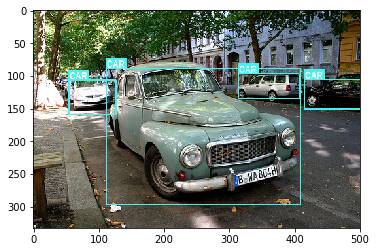

In [83]:
from detect import *
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
%matplotlib inline

if __name__ == '__main__':
    img_path = './data1/VOC2007/JPEGImages/000152.jpg'
    original_image = Image.open(img_path, mode='r')
    original_image = original_image.convert('RGB')
    img = detect(original_image, min_score=0.4, max_overlap=0.3, top_k=200)#0.2 0.5 200
    plt.imshow(img)
    plt.show()


## 作业：
查看源码中各个参数的具体含义之后，尝试修改__min_score__ ,__max_overlap__, __top_k__三个参数值,分析改动三个参数之后检测结果的变化。

## 答：
1. min_score与预测的置信度有关，当被检测出来的物体被识别为某个类别的置信度小于这个值的时候不用显示出来，如下所示，左边物体不是car，当我们将需要的最小的置信度提高到0.4的时候，物体没有被检测为car了。


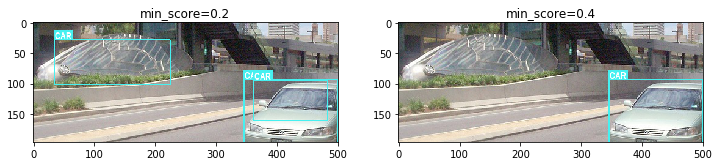

In [104]:
if __name__ == '__main__':
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))
    img_path = './data1/VOC2007/JPEGImages/000262.jpg'
    original_image = Image.open(img_path, mode='r')
    original_image = original_image.convert('RGB')
    img = detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200)#0.2 0.5 200
    original_image = Image.open(img_path, mode='r')
    original_image = original_image.convert('RGB')
    img1 = detect(original_image, min_score=0.4, max_overlap=0.5, top_k=200)#0.2 0.5 200
    ax[0].imshow(img)
    ax[0].set_title('min_score=0.2')
    ax[1].imshow(img1)
    ax[1].set_title('min_score=0.4')

2. max_overlap与被识别物体的重合部分有关，当重合部分的值与两个物体先验框的比例不超过这个max_overlap值的时候物体被检测的先验框显示在图片上。如下图所示，图的右上角有几个被检测出来的物体重合的范围很大，我们将允许重合的比例设置为0.1的时候，哪些重合比例超过0.1的被不被标记出来了。

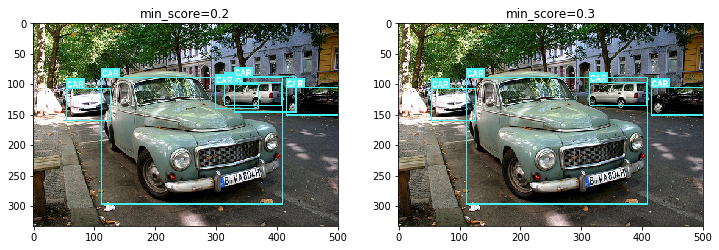

In [85]:
if __name__ == '__main__':
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))
    img_path = './data1/VOC2007/JPEGImages/000152.jpg'
    original_image = Image.open(img_path, mode='r')
    original_image = original_image.convert('RGB')
    img = detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200)#0.2 0.5 200
    ax[0].imshow(img)
    ax[0].set_title('min_score=0.2')
    original_image = Image.open(img_path, mode='r')
    original_image = original_image.convert('RGB')
    img1 = detect(original_image, min_score=0.2, max_overlap=0.1, top_k=200)#0.2 0.5 200
    ax[1].imshow(img1)
    ax[1].set_title('min_score=0.3')

3. top_k与要检测的物体的个数有关，显示被识别出来的置信度最高的k个物体。

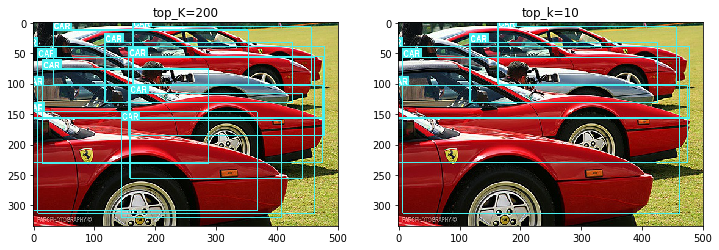

In [87]:
if __name__ == '__main__':
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))
    img_path = './data1/VOC2007/JPEGImages/000060.jpg'
    original_image = Image.open(img_path, mode='r')
    original_image = original_image.convert('RGB')
    img = detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200)#0.2 0.5 200
    original_image = Image.open(img_path, mode='r')
    original_image = original_image.convert('RGB')
    img1 = detect(original_image, min_score=0.2, max_overlap=0.5, top_k=5)#0.2 0.5 200
    ax[0].imshow(img)
    ax[0].set_title('top_K=200')
    ax[1].imshow(img1)
    ax[1].set_title('top_k=10')

## 模型评估  
计算模型分类的准确率，由于我们的数据集做了删减，只使用了VOC中的两类，因此只有两类会有准确率，其他类准确率为0

In [8]:
from eval import *
if __name__ == '__main__':
    evaluate(test_loader, model)

{'aeroplane': 0.0,
 'bicycle': 0.0,
 'bird': 0.0,
 'boat': 0.0,
 'bottle': 0.0,
 'bus': 0.0,
 'car': 0.014313836582005024,
 'cat': 0.0,
 'chair': 0.0,
 'cow': 0.0,
 'diningtable': 0.0,
 'dog': 0.0,
 'horse': 0.0,
 'motorbike': 0.0,
 'person': 0.0,
 'pottedplant': 0.0,
 'sheep': 0.0,
 'sofa': 0.0,
 'train': 0.014951499179005623,
 'tvmonitor': 0.0}

Mean Average Precision (mAP): 0.001


# 关于代码部分的补充
以上代码是从源码中提取出来，并且做了一些必要的修改之后的内容，主要是为了能够将目标检测任务的训练，评估，检测的过程以较为清晰的逻辑结构展示给大家。如果同学们已经基本掌握了以上内容，以下则是源码以.py文件的正确运行方式。  
__注意:__请勿在实验课上运行以下代码，因为源码内的参数是训练这个模型的默认参数，使用这组参数可以训练出一较为理想的检测模型，但是会占用大量GPU资源，如果同学们有自己的gpu，可以课后在自己的设备上运行，课上请勿使用该代码浪费GPU资源，谢谢配合。

In [ ]:
import train

# train model
# Setting the parameters you want in train.py file
train.main()

In [2]:
import detect
# detect
# Setting the parameters you want in detect.py file
detect.main()


Loaded checkpoint from epoch 11. Best loss so far is 5.796.



<Figure size 640x480 with 1 Axes>

In [ ]:
import eval

# evaluate the model
eval.main()

# 课后阅读部分
此部分是提供想要进一步了解ssd算法，有兴趣做目标检测任务的同学一些在代码方面更详细的解释，由于目标检测任务过程中会使用到非常多的数据处理，统计的工具函数，而此部分内容又基本都放在了utils.py文件中，因此我们将该文件做了一个大致的介绍，并且挑选出比较重要的部分为大家详细解释。

### utils.py文件解读
- 包括的函数有parse_annotation(), create_data_lists(), decimate(), calculate_mAP(), xy_to_cxcy(), cxcy_to_xy(), cxcy_to_gcxgcy(), gcxgcy_to_cxcy(), find_intersection(), find_jaccard_overlap(), expand(), random_crop(), flip(), resize(), photometric_distort(), transform(),
 adjust_learning_rate(), accuracy(), save_checkpoint(), clip_gradient()等。
- 其中有些函数这里就不详细讲了希望大家有兴趣的可以课下仔细阅读下，比如用于图像数据增强的函数expand(), random_crop(), flip(), resize(), photometric_distort(), transform()，这些函数不仅可以用于目标检测还可以用在分类等其他领域。
- adjust_learning_rate(), accuracy(), save_checkpoint(), clip_gradient()等函数则是用于常规深度学习工具函数，这里也不再详细介绍。
- parse_annotation()函数主要是辅助create_data_lists()这个函数完成VOC2007数据集XML文件解析的，而create_data_lists()函数则是解析原始VOC2007数据集生成对应实际训练中载入的Json文件即TRAIN_images.json, TRAIN_objects.json, TEST_images.json, TEST_objects.json, lable_map.json。
- decimate()函数主要是在进行全连接层转化为卷积的时候进行间隔抽样，以达成空洞卷积的目的。

- calculate_mAP()函数是计算mAP即Mean Average Precision，这一指标是近年来用来衡量目标检测算法性能的重要指标，它的核心原理如下：
>* 将所有的detection_box按detection_score进行排序
>* 计算每个detection_box与所有groundtruth_box的IOU
>* 取IOU最大(max_IOU)的groundtruth_box作为这个detection_box的预测结果是否正确的判断依据，然后根据max_IOU的结果判断预测结果是TP还是FP进而画出PR曲线，最后再在每一类上做平均得到mAP。
>* 一个不错的深入了解链接.[mAP详解](https://github.com/rafaelpadilla/Object-Detection-Metrics)

- find_intersection()以及find_jaccard_overlap()函数即为计算IoU的，这个在之前分割实验课上有介绍过。其实现如下：

In [ ]:
def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.

    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)

计算完相交的部分后，计算IoU便比较简单，只需要用相交部分除以相并的部分

In [ ]:
def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.

    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

#### 非极大值抑制（Non-Maximum Suppression，NMS）
NMS是目标检测的重要算法，它的作用是用来去掉模型预测后的多余框。如下图所示:
- NMS算法处理前
![NMS1](picture/NMS1.jpg)
- NMS算法处理后
![NMS2](picture/NMS2.jpg)

- 算法流程
>* 设定一个阈值IOU假设为0.5，选取每一类box中scores最大的那一个，记为box_best，并保留它
>* 计算box_best与其余的box的IOU，如果其IOU>0.5了，那么就舍弃这个box（由于可能这两个box表示同一目标，所以保留分数高的哪一个）
>* 从最后剩余的boxes中，再找出最大scores的哪一个，如此循环往复

- 一个简单的例子
>* 比如现在滑动窗口有：A、B、C、D、E、F、G、H、I、J个，假设A是得分最高的，IOU＞0.7淘汰。 第一轮：与A计算IOU，BEG＞0.7，剔除，剩余CDFHIJ 第二轮：假设CDFHIJ中F得分最高，与F计算IOU，DHI＞0.7，剔除，剩余CJ 第三轮：假设CJ中C得分最高，J与C计算IOU，若结果＞0.7，则AFC就是选择出来的窗口。  

- SSD中非极大值抑制的实现

In [ ]:
def NMS(n_classes, predicted_scores, min_score, decoded_locs, max_overlap, image_boxes,  
        image_labels, image_scores):
    for c in range(1, n_classes):
        # Keep only predicted boxes and scores where scores for this class are above the minimum score
        class_scores = predicted_scores[i][:, c]  # (8732)
        score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor, for indexing
        n_above_min_score = score_above_min_score.sum().item()
        if n_above_min_score == 0:
            continue
        class_scores = class_scores[score_above_min_score]  # (n_qualified), n_min_score <= 8732
        class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

        # Sort predicted boxes and scores by scores
        class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
        class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

        # Find the overlap between predicted boxes
        overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

        # Non-Maximum Suppression (NMS)

        # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
        # 1 implies suppress, 0 implies don't suppress
        suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)

        # Consider each box in order of decreasing scores
        for box in range(class_decoded_locs.size(0)):
            # If this box is already marked for suppression
            if suppress[box] == 1:
                continue

            # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
            # Find such boxes and update suppress indices
            suppress = torch.max(suppress, overlap[box] > max_overlap)
            # The max operation retains previously suppressed boxes, like an 'OR' operation

            # Don't suppress this box, even though it has an overlap of 1 with itself
            suppress[box] = 0

        # Store only unsuppressed boxes for this class
        image_boxes.append(class_decoded_locs[1 - suppress])
        image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
        image_scores.append(class_scores[1 - suppress])

#### 课后作业（不要求提交，有兴趣的同学可以去尝试一下）
1. 实现并分析NMS算法
使用VOC2007或者VOC2012数据集中的任意一张图像，自己模拟目标检测中NMS函数的输入，即输入自己人工设置一些detection box（数量大于5，类别数大于等于2）的位置和大小同时给定任意的score。实现NMS算法的函数，并可视化NMS算法处理效果如上面的示例图。